In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt

import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.models as models
import mlgrad.funcs as funcs
import mlgrad.loss as loss
import mlgrad.gd as gd

In [3]:
digits = load_digits()

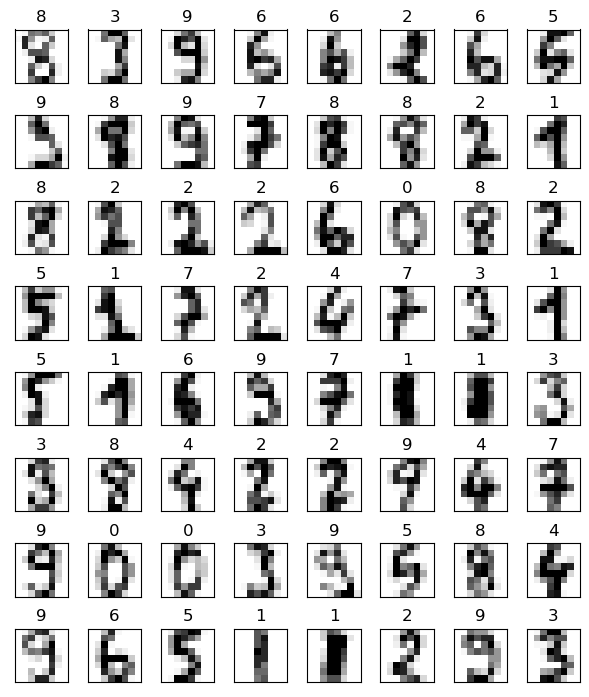

In [66]:
I = np.random.randint(0,len(Y),64)
II = I.reshape(8,8)
plt.figure(figsize=(6,7))
for i in range(8):
    for j in range(8):
        plt.subplot(8,8,8*i+j+1)
        plt.imshow(X[II[i,j]].reshape(8,8), cmap=plt.cm.Greys)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(Y[II[i,j]]))
plt.tight_layout()
plt.show()

In [57]:
Y = np.ascontiguousarray(digits.target)
X = np.ascontiguousarray(digits.data)
print(len(Y))

1797


In [17]:
I1 = (Y == 1)
I7 = (Y == 7)
X1 = X[I1]
Y1 = np.ones(len(X1), 'd')
X7 = X[I7]
Y7 = -np.ones(len(X7), 'd')

X17 = np.concatenate((X1, X7), axis=0)
Y17 = np.concatenate((Y1, Y7))

N = len(Y17)
print(X17.shape, Y17.shape)

(361, 64) (361,)


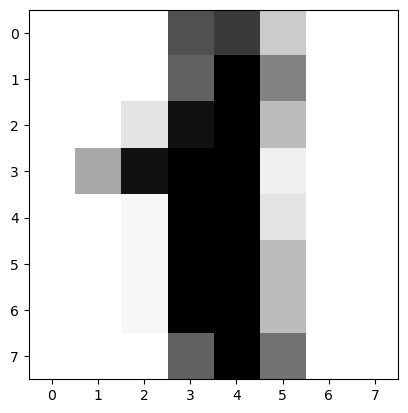

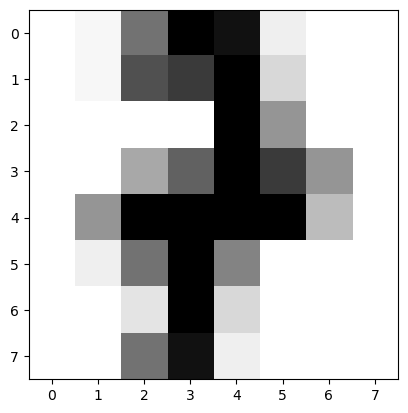

In [18]:
plt.imshow(X17[0].reshape(8,8), plt.cm.Greys)
plt.show()
plt.imshow(X17[-1].reshape(8,8), plt.cm.Greys)
plt.show()

In [19]:
mod = models.LinearModel(64)
hinge_loss = loss.MarginLoss(funcs.Hinge(1.0))

In [20]:
alg = cls.classification_as_regr(X17, Y17, mod,
                                 lossfunc=hinge_loss, 
                                 normalizer=gd.LinearModelNormalizer(),
                                 h=0.01, n_iter=5000)
print(mod.param.base)
print(np.sqrt(np.sum(mod.param.base[1:]**2)))

[ 0.016  0.072 -0.116  0.014 -0.109 -0.023  0.003 -0.109 -0.083  0.102
 -0.123 -0.115 -0.033  0.067  0.029 -0.084 -0.102  0.478 -0.027  0.002
  0.196  0.048 -0.056 -0.138 -0.087  0.479  0.119  0.022  0.011  0.027
 -0.065 -0.114  0.041  0.003 -0.080 -0.011 -0.094  0.059 -0.059 -0.028
  0.124  0.098 -0.068  0.046  0.007  0.076 -0.064 -0.055  0.074  0.185
  0.009  0.068 -0.091  0.056  0.097  0.243  0.167  0.165 -0.070 -0.025
 -0.023  0.143  0.051  0.162  0.145]
0.9999999999999999


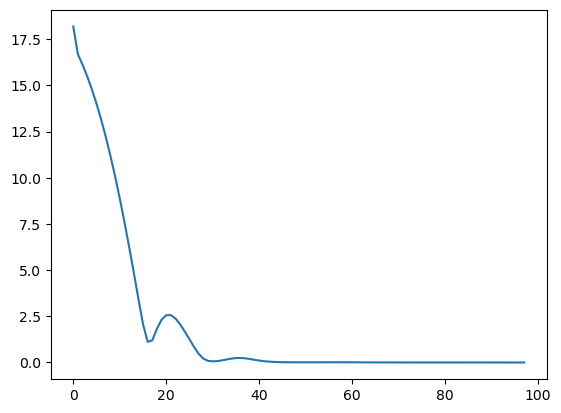

In [21]:
plt.plot(alg.lvals)
plt.show()

In [22]:
metrics.accuracy_score(Y17, np.sign(mod.evaluate_all(X17)))

1.0

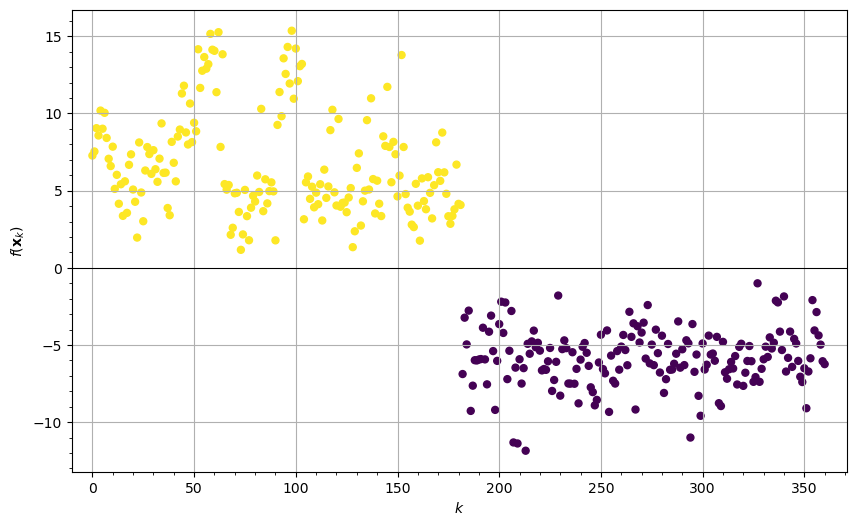

In [23]:
plt.figure(figsize=(10,6))
plt.scatter(range(N), mod.evaluate_all(X17), c=Y17, s=25)
plt.hlines(0, -10, N+10, colors='k', linewidths=0.75)
plt.minorticks_on()
plt.grid(1)
plt.xlim(-10, N+10)
plt.xlabel(r'$k$')
plt.ylabel(r'$f(\mathbf{x}_k)$')
plt.show()

In [40]:
mod_pairs = {}
alg_pairs = {}
for i in range(9):
    for j in range(i+1,10):
        mod_pairs[(i,j)] = mod = models.LinearModel(64)
        II = (Y == i)
        IJ = (Y == j)
        XI = X[II]
        YI = np.ones(len(XI), 'd')
        XJ = X[IJ]
        YJ = -np.ones(len(XJ), 'd')
        
        XIJ = np.concatenate((XI, XJ), axis=0)
        YIJ = np.concatenate((YI, YJ))

        alg_pairs[(i,j)] = alg = cls.classification_as_regr(
                                 XIJ, YIJ, mod,
                                 lossfunc=hinge_loss, 
                                 # normalizer=gd.LinearModelNormalizer(),
                                 h=0.1, n_iter=5000)
        p = mod.param.base
        mod.param.base[:] = mod.param.base / np.sqrt(p @ p)
        print(f"({i},{j}):", metrics.accuracy_score(YIJ, np.sign(mod.evaluate_all(XIJ))))

(0,1): 1.0
(0,2): 1.0
(0,3): 1.0
(0,4): 1.0
(0,5): 1.0
(0,6): 1.0
(0,7): 1.0
(0,8): 1.0
(0,9): 1.0
(1,2): 1.0
(1,3): 1.0
(1,4): 1.0
(1,5): 1.0
(1,6): 1.0
(1,7): 1.0
(1,8): 1.0
(1,9): 1.0
(2,3): 1.0
(2,4): 0.9581005586592178
(2,5): 1.0
(2,6): 1.0
(2,7): 1.0
(2,8): 1.0
(2,9): 1.0
(3,4): 0.9972527472527473
(3,5): 1.0
(3,6): 1.0
(3,7): 1.0
(3,8): 1.0
(3,9): 1.0
(4,5): 0.9917355371900827
(4,6): 1.0
(4,7): 1.0
(4,8): 0.9661971830985916
(4,9): 1.0
(5,6): 1.0
(5,7): 1.0
(5,8): 1.0
(5,9): 1.0
(6,7): 1.0
(6,8): 1.0
(6,9): 1.0
(7,8): 1.0
(7,9): 1.0
(8,9): 1.0


In [45]:
def decision_func(mod_pairs, x, y):
    d = np.zeros((10,10), 'd')
    for i in range(9):
        for j in range(i+1,10):
            mod = mod_pairs[(i,j)]
            yp = np.sign(mod.evaluate_all(x[None,:]))
            d[i,j] = yp
            d[j,i] = -yp
    return d

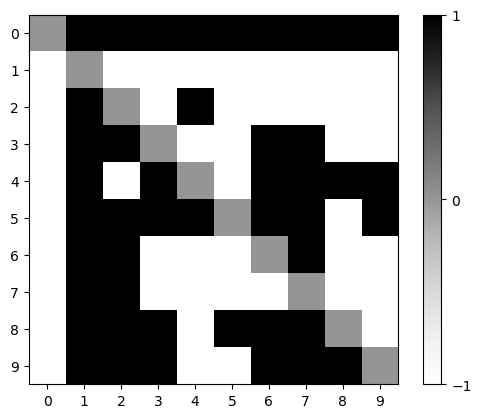

In [55]:
d = decision_func(mod_pairs, X[0], Y[0])
cs = plt.imshow(d, cmap=plt.cm.Greys)
plt.colorbar(cs, ticks=[-1,0,1])
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

In [49]:
np.argmax(np.sum(decision_func(mod_pairs, X[0], Y[0]), axis=1))

0

In [50]:
for k in range(len(Y)):
    xk, yk = X[k], Y[k]
    yy = np.argmax(np.sum(decision_func(mod_pairs, xk, yk), axis=1))
    if yy != yk:
        print(k, yk, yy)

54 2 1
75 2 1
77 2 1
158 8 1
678 5 4
804 8 1
905 8 1
1553 8 1
1581 8 4
1597 2 1
1611 4 8
1628 4 8
1660 4 8


In [58]:
(13 / len(Y)) * 100

0.7234279354479688